## Step 1: Load Dataset

In [1]:
import kagglehub

path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arxiv


## Step 2: Import Libraries

In [2]:
import json
import pandas as pd
from itertools import combinations
import networkx as nx

## Step 3: Load JSON and Convert to DataFrame

In [3]:
data = []
with open("/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json", 'r') as f:
    for line in f:
        paper = json.loads(line)
        data.append({
            'id': paper['id'],
            'title': paper['title'],
            'authors': paper['authors'],
            'categories': paper['categories'],
            'update_date': paper['update_date']
        })

df = pd.DataFrame(data)

## Step 4: Build the Co-Author Network

### Generate Edge List

In [4]:
import re
from itertools import combinations

with open('edges.txt', 'w') as f:
    for author_str in df['authors'].dropna():
        authors = []
        stopwords = {'and', 'et', 'al', 'of', 'for', 'in', 'on', 'to', 'from', 'by'}

        for a in author_str.split(','):
            a_clean = a.strip().strip('.,;:()[]{}')
            a_lower = a_clean.lower()

            if len(a_clean) <= 1:
                continue

            if a_lower in stopwords:
                continue

            if any(char.isdigit() for char in a_clean):
                continue
            if any(c in a_clean for c in '()[]{}'):
                continue

            if re.fullmatch(r'[A-Z]\.?', a_clean):
                continue

            if not re.search(r'[a-zA-Z]', a_clean):
                continue

            if len(a_clean.split()) < 2:
                continue
            if len(a_clean) < 4:
                continue

            if not re.match(r'^[A-Z][a-z]+(\s[A-Z]\.)?\s[A-Z][a-z]+$', a_clean):
                continue

            authors.append(a_clean)

        if len(authors) > 20:
            continue

        for pair in combinations(authors, 2):
            edge = tuple(sorted(pair))
            f.write(f"{edge[0]}\t{edge[1]}\n")

In [5]:
edges = []
with open("edges.txt", "r") as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            continue
        author1, author2 = parts
        edges.append((author1, author2))

## Step 5: Create and Analyze the Graph

### NetworkX

In [6]:
G = nx.Graph()
G.add_edges_from(edges)

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Nodes: 854560
Edges: 5602900


In [7]:
bad_nodes = [n for n in G.nodes if n.lower() in stopwords or len(n) <= 2 or re.fullmatch(r'[A-Z]\.?', n)]
G.remove_nodes_from(bad_nodes)

### Centrality Analysis

In [8]:
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top authors by degree centrality:", top_authors)

Top authors by degree centrality: [('Yang Liu', 0.0053267240763949595), ('Takashi Taniguchi', 0.005042366881631345), ('Kenji Watanabe', 0.00491364551774658), ('Wei Wang', 0.00397280936717067), ('Wei Zhang', 0.0034040949776434396), ('Yu Zhang', 0.0030612280720231136), ('Wei Li', 0.003019101080206282), ('Lei Zhang', 0.002980484671040853), ('Yang Li', 0.002975803894172316), ('Xiang Li', 0.002896230687407189)]


## Step 6: Visualizations

### I. Degree Distribution

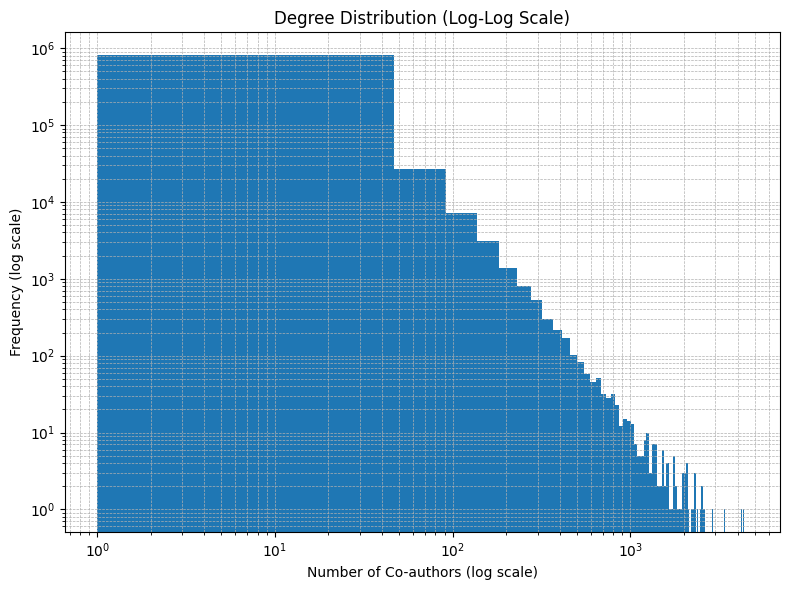

In [9]:
import matplotlib.pyplot as plt

degrees = [deg for node, deg in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=100, log=True)
plt.xscale('log')
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Number of Co-authors (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

This **log-log degree distribution plot** clearly shows that this arXiv co-authorship network follows a **heavy-tailed distribution**, likely a power-law — a hallmark of scale-free networks.<br>

This indicates that:<br>
- Most authors have few co-authors.

- A small number of authors collaborate with hundreds or even thousands.

- This supports _Barabási–Albert preferential attachment model_ behavior, which is common in real-world networks like:

- Citation networks

- Social networks

- Collaboration graphs (like this one)

### II. Subgraph for Top Authors

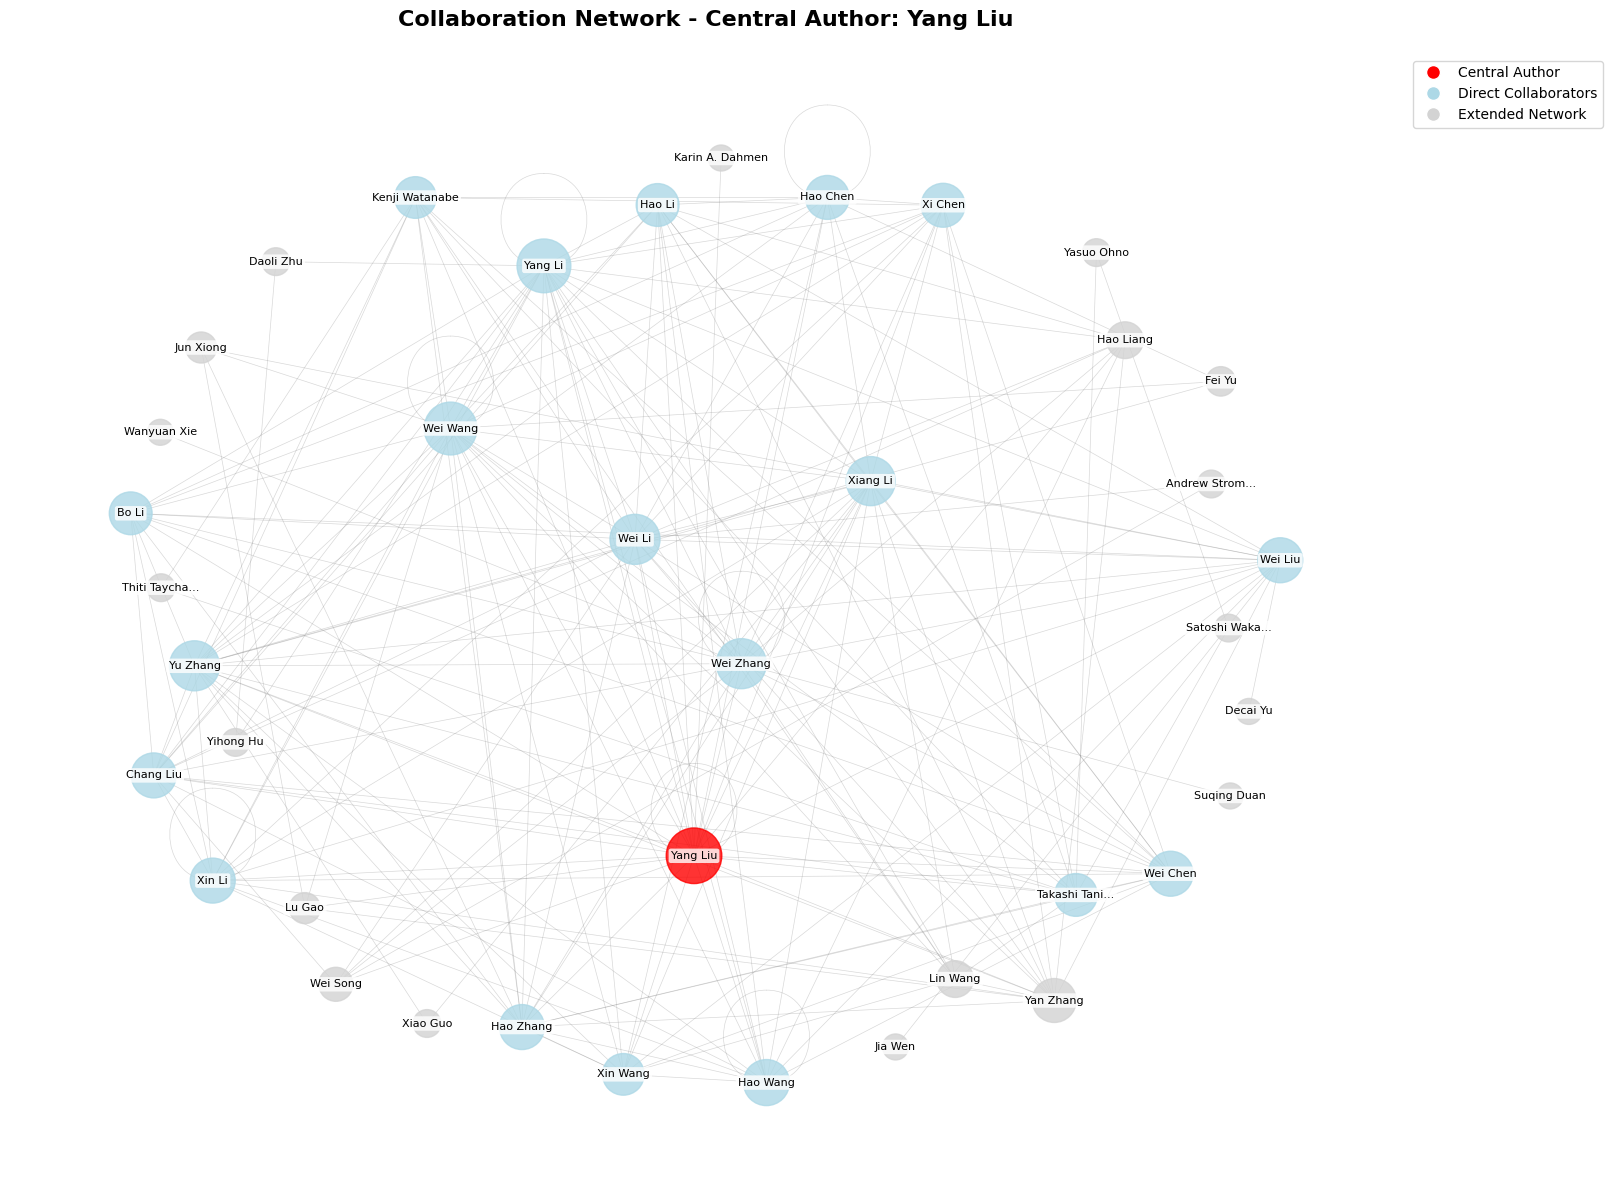

Network Statistics:
Number of nodes: 39
Number of edges: 200
Network density: 0.270
Central author degree: 26

Detailed Analysis for Yang Liu:
Total collaborators: 4552

Top 10 Collaborators by Degree:
 1. Yang Liu                       (degree: 4552)
 2. Takashi Taniguchi              (degree: 4309)
 3. Kenji Watanabe                 (degree: 4199)
 4. Wei Wang                       (degree: 3395)
 5. Wei Zhang                      (degree: 2909)
 6. Yu Zhang                       (degree: 2616)
 7. Wei Li                         (degree: 2580)
 8. Yang Li                        (degree: 2543)
 9. Xiang Li                       (degree: 2475)
10. Wei Liu                        (degree: 2369)

Average clustering coefficient: 0.555


In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

def create_readable_network(G, top_authors, max_nodes=50, figsize=(16, 12)):
    """
    Create a more readable network visualization
    """
    top_author = top_authors[0][0]

    ego_full = nx.ego_graph(G, top_author, radius=2)

    neighbors = sorted(ego_full.neighbors(top_author),
                      key=lambda n: G.degree(n), reverse=True)[:max_nodes//2]

    selected_nodes = [top_author] + neighbors
    for neighbor in neighbors[:10]:
        second_degree = list(G.neighbors(neighbor))[:2]
        selected_nodes.extend(second_degree)

    ego_small = G.subgraph(set(selected_nodes))

    fig, ax = plt.subplots(figsize=figsize)

    pos = nx.spring_layout(ego_small, k=3, iterations=50, seed=42)

    degrees = dict(ego_small.degree())
    node_sizes = [300 + degrees[node] * 50 for node in ego_small.nodes()]

    color_map = []
    for node in ego_small.nodes():
        if node == top_author:
            color_map.append('red')
        elif node in neighbors:
            color_map.append('lightblue')
        else:
            color_map.append('lightgray')

    nx.draw_networkx_edges(ego_small, pos, alpha=0.3, width=0.5,
                          edge_color='gray', ax=ax)

    nx.draw_networkx_nodes(ego_small, pos, node_color=color_map,
                          node_size=node_sizes, alpha=0.8, ax=ax)

    labels = {}
    for node in ego_small.nodes():
        if len(str(node)) > 15:
            labels[node] = str(node)[:12] + "..."
        else:
            labels[node] = str(node)

    for node, (x, y) in pos.items():
        ax.text(x, y, labels[node], fontsize=8, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white',
                         alpha=0.8, edgecolor='none'))

    ax.set_title(f'Collaboration Network - Central Author: {top_author}',
                fontsize=16, fontweight='bold', pad=20)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                   markersize=10, label='Central Author'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                   markersize=10, label='Direct Collaborators'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray',
                   markersize=10, label='Extended Network')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    ax.set_axis_off()

    plt.tight_layout()

    return fig, ax, ego_small

def create_interactive_network(G, top_authors, max_nodes=50):
    """
    Create an interactive network visualization using plotly
    """
    try:
        import plotly.graph_objects as go
        import plotly.express as px
    except ImportError:
        print("Plotly not available. Install with: !pip install plotly")
        return None

    top_author = top_authors[0][0]
    ego_full = nx.ego_graph(G, top_author, radius=2)

    neighbors = sorted(ego_full.neighbors(top_author),
                      key=lambda n: G.degree(n), reverse=True)[:max_nodes//2]

    selected_nodes = [top_author] + neighbors
    for neighbor in neighbors[:10]:
        second_degree = list(G.neighbors(neighbor))[:2]
        selected_nodes.extend(second_degree)

    ego_small = G.subgraph(set(selected_nodes))
    pos = nx.spring_layout(ego_small, k=3, iterations=50, seed=42)

    edge_x = []
    edge_y = []
    for edge in ego_small.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='gray'),
                           hoverinfo='none', mode='lines')

    node_x = []
    node_y = []
    node_text = []
    node_color = []

    for node in ego_small.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f'{node}<br>Degree: {ego_small.degree(node)}')

        if node == top_author:
            node_color.append('red')
        elif node in neighbors:
            node_color.append('lightblue')
        else:
            node_color.append('lightgray')

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text',
                           hoverinfo='text', text=list(ego_small.nodes()),
                           textposition="middle center", hovertext=node_text,
                           marker=dict(size=10, color=node_color))

    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(title=f'Interactive Collaboration Network - Central: {top_author}',
                                   titlefont_size=16, showlegend=False,
                                   hovermode='closest', margin=dict(b=20,l=5,r=5,t=40),
                                   annotations=[dict(text="Hover over nodes for details",
                                                   showarrow=False, xref="paper", yref="paper",
                                                   x=0.005, y=-0.002, xanchor='left', yanchor='bottom',
                                                   font=dict(color="gray", size=12))],
                                   xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                   yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    return fig

fig, ax, network = create_readable_network(G, top_authors, max_nodes=40)
plt.show()

print(f"Network Statistics:")
print(f"Number of nodes: {network.number_of_nodes()}")
print(f"Number of edges: {network.number_of_edges()}")
print(f"Network density: {nx.density(network):.3f}")
print(f"Central author degree: {network.degree(top_authors[0][0])}")

def analyze_network_properties(G, top_authors):
    """
    Analyze and display network properties
    """
    top_author = top_authors[0][0]

    print(f"\nDetailed Analysis for {top_author}:")
    print(f"{'='*50}")

    print(f"Total collaborators: {G.degree(top_author)}")

    collaborators = list(G.neighbors(top_author))
    collab_degrees = [(collab, G.degree(collab)) for collab in collaborators]
    collab_degrees.sort(key=lambda x: x[1], reverse=True)

    print(f"\nTop 10 Collaborators by Degree:")
    for i, (collab, degree) in enumerate(collab_degrees[:10], 1):
        print(f"{i:2d}. {collab[:30]:<30} (degree: {degree})")

    if nx.is_connected(G.subgraph([top_author] + collaborators)):
        try:
            avg_clustering = nx.average_clustering(G.subgraph([top_author] + collaborators))
            print(f"\nAverage clustering coefficient: {avg_clustering:.3f}")
        except:
            print("\nClustering coefficient: Cannot calculate")

    return collab_degrees

analysis_results = analyze_network_properties(G, top_authors)

#### **Interpretations:**
1. Yang Liu has 4,552 collaborators, making them the most connected author in the dataset. Yang Liu appears to be a **"super-connector"** - bridging different research communities.
2. Yang Liu's central position suggests potential roles as:
 - Principal investigator on large collaborative projects
 - Bridge between international research groups
 - Key figure in interdisciplinary research
3. The degree centrality indicates Yang Liu is a major hub in the research network.
4. A network density of 0.270 is relatively high, indicating Yang Liu's collaborators often work together
5. Multiple researchers with surnames Li, Wang, Zhang, Liu indicate significant collaboration within Chinese research networks.
6. The mix of Chinese and international names suggests Yang Liu bridges different research communities.


### III. Temporal Networks: Yearly Evolution

In [23]:
df['year'] = pd.to_datetime(df['update_date']).dt.year

In [25]:
import re
from itertools import combinations

years = sorted(df['year'].dropna().unique())

stopwords = {'and', 'et', 'al', 'of', 'for', 'in', 'on', 'to', 'from', 'by'}

for year in years:
    df_year = df[df['year'] == year]

    edges_year = set()

    for author_str in df_year['authors'].dropna():
        authors = []

        for a in author_str.split(','):
            a_clean = a.strip().strip('.,;:()[]{}')
            a_lower = a_clean.lower()

            if len(a_clean) <= 1:
                continue
            if a_lower in stopwords:
                continue
            if any(char.isdigit() for char in a_clean):
                continue
            if any(c in a_clean for c in '()[]{}'):
                continue
            if re.fullmatch(r'[A-Z]\.?', a_clean):
                continue
            if not re.search(r'[a-zA-Z]', a_clean):
                continue

            authors.append(a_clean)

        if len(authors) > 20:
            continue

        for pair in combinations(authors, 2):
            edge = tuple(sorted(pair))
            edges_year.add(edge)

    G_year = nx.Graph()
    G_year.add_edges_from(edges_year)

    print(f"{year} - Nodes: {G_year.number_of_nodes()}, Edges: {G_year.number_of_edges()}")

2007 - Nodes: 107679, Edges: 286758
2008 - Nodes: 70554, Edges: 198340
2009 - Nodes: 201013, Edges: 780822
2010 - Nodes: 67430, Edges: 178400
2011 - Nodes: 77868, Edges: 208885
2012 - Nodes: 74561, Edges: 197258
2013 - Nodes: 98211, Edges: 266073
2014 - Nodes: 119570, Edges: 335240
2015 - Nodes: 277547, Edges: 1239109
2016 - Nodes: 197725, Edges: 664775
2017 - Nodes: 195742, Edges: 664919
2018 - Nodes: 226832, Edges: 794921
2019 - Nodes: 256401, Edges: 913850
2020 - Nodes: 302998, Edges: 1123471
2021 - Nodes: 323912, Edges: 1219324
2022 - Nodes: 338334, Edges: 1330591
2023 - Nodes: 383665, Edges: 1580963
2024 - Nodes: 471050, Edges: 2114138
2025 - Nodes: 389247, Edges: 1789483


#### Plot Growth Over Time

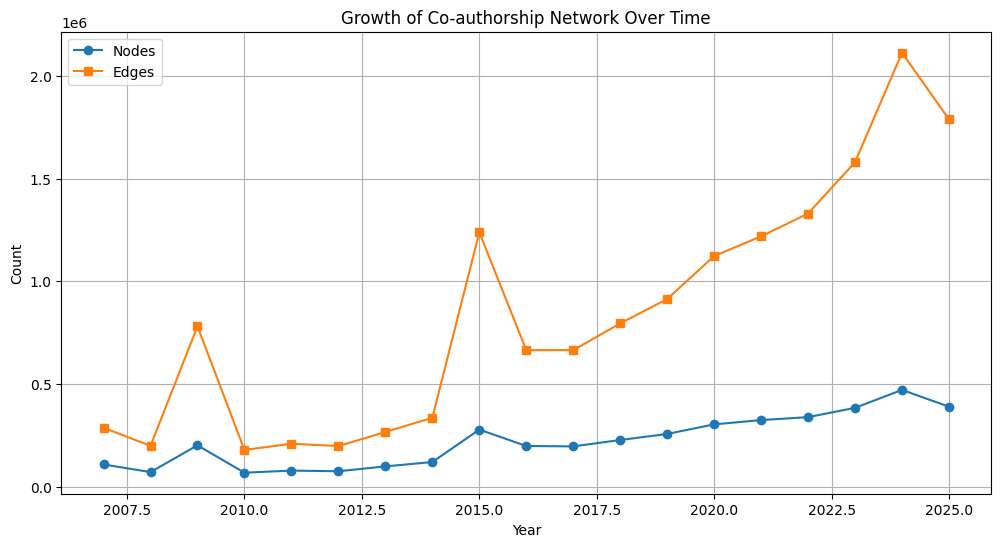

In [26]:
import matplotlib.pyplot as plt

years_list = []
nodes_list = []
edges_list = []

for year in years:
    df_year = df[df['year'] == year]
    edges_year = set()
    for author_str in df_year['authors'].dropna():
        authors = []
        for a in author_str.split(','):
            a_clean = a.strip().strip('.,;:()[]{}')
            a_lower = a_clean.lower()
            if len(a_clean) <= 1 or a_lower in stopwords:
                continue
            if any(char.isdigit() for char in a_clean) or any(c in a_clean for c in '()[]{}'):
                continue
            if re.fullmatch(r'[A-Z]\.?', a_clean) or not re.search(r'[a-zA-Z]', a_clean):
                continue
            authors.append(a_clean)
        if len(authors) > 20:
            continue
        for pair in combinations(authors, 2):
            edge = tuple(sorted(pair))
            edges_year.add(edge)

    G_year = nx.Graph()
    G_year.add_edges_from(edges_year)

    years_list.append(year)
    nodes_list.append(G_year.number_of_nodes())
    edges_list.append(G_year.number_of_edges())

plt.figure(figsize=(12, 6))
plt.plot(years_list, nodes_list, label='Nodes', marker='o')
plt.plot(years_list, edges_list, label='Edges', marker='s')
plt.title('Growth of Co-authorship Network Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

 **Interpretations:**
 - The edges grow much faster than nodes, indicating that existing researchers are collaborating more frequently rather than just new researchers joining the field.
 -  The ratio of edges to nodes increases dramatically over time, suggesting the research community is becoming more interconnected.
 - The edges show much more volatility than nodes, with several peaks and valleys, possibly reflecting changes in research funding, publication practices, or data collection methods.
 - The 2024-2025 drop might indicate incomplete recent data, changes in publication patterns, or shifts in collaboration practices.